In [1]:
import imageio

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import cv2

In [3]:
img_rgb = imageio.imread('toad_and_jiang.jpg')

In [4]:
img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

In [5]:
toad = img[:,:140]

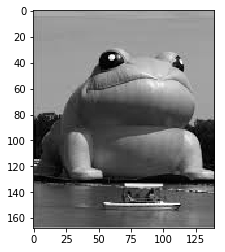

In [6]:
plt.imshow(toad, cmap='gray')

In [7]:
toad_noised = np.clip(toad + 25*np.random.randn(*toad.shape), 0,255)

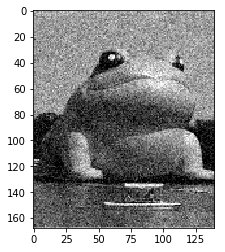

In [8]:
plt.imshow(toad_noised, cmap='gray')

In [9]:
import scipy

In [10]:
import scipy.ndimage

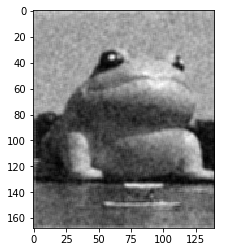

In [11]:
plt.imshow(scipy.ndimage.convolve(toad_noised, np.full((3,3),1/9)), cmap='gray')

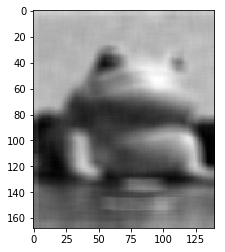

In [12]:
plt.imshow(scipy.ndimage.convolve(toad_noised, np.full((10,10),1/100)), cmap='gray')

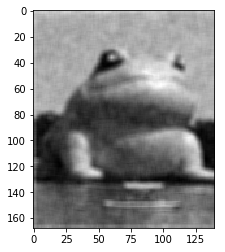

In [13]:
plt.imshow(scipy.ndimage.convolve(toad_noised, np.full((5,5),1/25)), cmap='gray')

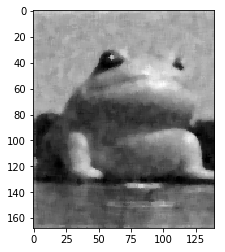

In [14]:
plt.imshow(scipy.ndimage.median_filter(toad_noised, 5), cmap='gray')

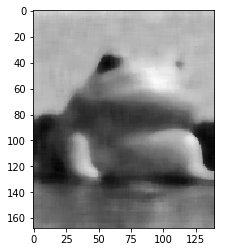

In [15]:
plt.imshow(scipy.ndimage.median_filter(toad_noised, 10), cmap='gray')

In [16]:
toad_noised = np.clip(toad + 15*np.random.randn(*toad.shape), 0,255)

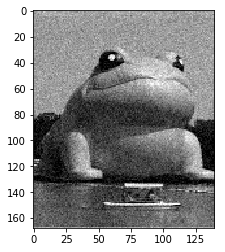

In [17]:
plt.imshow(toad_noised, cmap='gray')

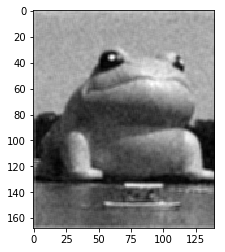

In [18]:
plt.imshow(scipy.ndimage.convolve(toad_noised, np.full((3,3),1/9)), cmap='gray')

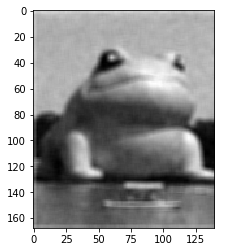

In [19]:
plt.imshow(scipy.ndimage.convolve(toad_noised, np.full((5,5),1/9)), cmap='gray')

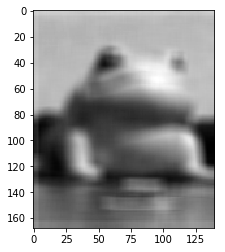

In [20]:
plt.imshow(scipy.ndimage.convolve(toad_noised, np.full((10,10),1/9)), cmap='gray')

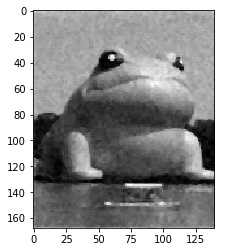

In [21]:
plt.imshow(scipy.ndimage.median_filter(toad_noised, 3), cmap='gray')

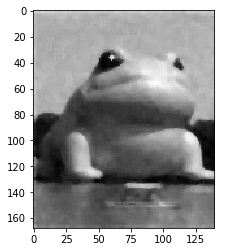

In [22]:
plt.imshow(scipy.ndimage.median_filter(toad_noised, 5), cmap='gray')

In [23]:
toad.shape

(168, 140)

In [24]:
np.prod(toad.shape)

23520

In [25]:
jj,ii = np.meshgrid(np.arange(toad.shape[1]), np.arange(toad.shape[0]))

In [26]:
ii.shape

(168, 140)

In [27]:
jj.shape

(168, 140)

In [28]:
ii

array([[  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   1, ...,   1,   1,   1],
       [  2,   2,   2, ...,   2,   2,   2],
       ...,
       [165, 165, 165, ..., 165, 165, 165],
       [166, 166, 166, ..., 166, 166, 166],
       [167, 167, 167, ..., 167, 167, 167]])

In [29]:
jj

array([[  0,   1,   2, ..., 137, 138, 139],
       [  0,   1,   2, ..., 137, 138, 139],
       [  0,   1,   2, ..., 137, 138, 139],
       ...,
       [  0,   1,   2, ..., 137, 138, 139],
       [  0,   1,   2, ..., 137, 138, 139],
       [  0,   1,   2, ..., 137, 138, 139]])

In [30]:
iijj = np.stack([ii,jj],2)
iijj.shape

(168, 140, 2)

In [31]:
IJ = iijj.reshape(-1,2).astype(float)
IJ.shape

(23520, 2)

In [32]:
IJ[:5,:],IJ[1995:2000,:]

(array([[0., 0.],
        [0., 1.],
        [0., 2.],
        [0., 3.],
        [0., 4.]]), array([[14., 35.],
        [14., 36.],
        [14., 37.],
        [14., 38.],
        [14., 39.]]))

局部线性回归好像没提供什么特殊计算方式，直接用它的不考虑交叉检验都要计算23520次来得到所有结果可还行。但试图batch处理的话，
那个$W_x$的等价物相当于一个$23520 \times 23520$矩阵，这个没法存。当然可以考虑每个batch 100个什么的那样算。。简直吃饱了没事。
先看看不用batch的算出来多慢再说，不过这么折腾cross validation肯定是没法做了。

In [33]:
ij = np.array([50, 100]).astype(float)

In [34]:
import scipy.stats as stats

In [35]:
dis = stats.norm()
K = lambda x:dis.pdf(x) # h=1

In [36]:
Wx = K(np.abs(ij - IJ).sum(axis=1))

In [37]:
_X = (ij - IJ).sum(axis=1)

In [38]:
X = np.c_[np.ones_like(_X), _X]

In [39]:
X.shape

(23520, 2)

In [40]:
#Y = toad.reshape(-1,1) # terrible bug
Y = toad_noised.reshape(-1,1)

In [41]:
a = np.linalg.inv((X.T * Wx) @ X) @ (X.T * Wx) @ Y

In [42]:
a

array([[211.39140619],
       [ -2.87062018]])

In [43]:
from itertools import product

In [44]:
list(product(range(3),range(3)))

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

In [45]:
ij

array([ 50., 100.])

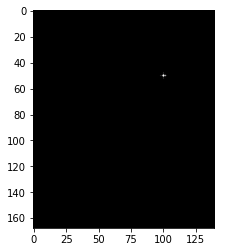

In [46]:
plt.imshow(Wx.reshape(toad.shape), cmap='gray')

In [47]:
np.concatenate([[1,2,3],[4]])

array([1, 2, 3, 4])

In [48]:
%%time

mat = np.empty(toad.shape+(3,))
for _ij in product(range(toad.shape[0]), range(toad.shape[1])):
    ij = np.array(_ij).astype(float)
    Wx = K(np.abs(ij - IJ).sum(axis=1))
    _X = (ij - IJ).sum(axis=1)
    X = np.c_[np.ones_like(_X), _X]

    l = np.linalg.inv((X.T * Wx) @ X) @ (X.T * Wx)
    a = l @ Y

    mat[_ij[0], _ij[1], :] = np.concatenate([a.squeeze(), [np.sum(l**2)]])

Wall time: 2min 35s


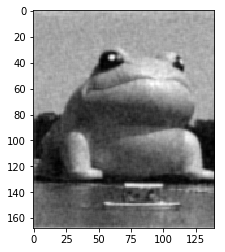

In [49]:
plt.imshow(mat[:,:,0], cmap='gray')

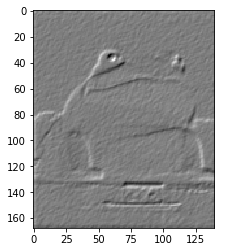

In [50]:
plt.imshow(mat[:,:,1], cmap='gray')

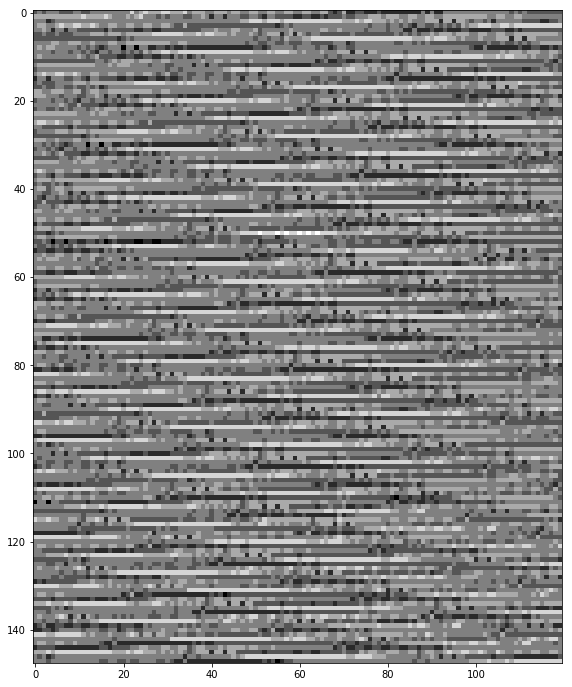

In [51]:
plt.figure(figsize=(12,12))
plt.imshow((mat[10:-10,10:-10,2] - mat[10:-10,10:-10,2].min())/(mat[10:-10,10:-10,2].max()-mat[10:-10,10:-10,2].min()), cmap='gray') # ignore sigma, since we focus on only variance 

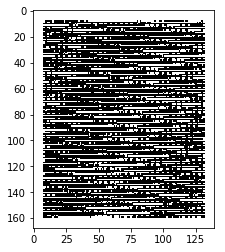

In [52]:
plt.imshow(mat[:,:,2] > np.median(mat[:,:,2]), cmap='gray')

In [53]:
mat[:,:,2]

array([[1.05929306, 0.39378923, 0.28884265, ..., 0.28128113, 0.30219219,
        0.39021288],
       [0.39378923, 0.22123114, 0.19011978, ..., 0.18907939, 0.20888761,
        0.30219219],
       [0.28884265, 0.19011978, 0.17014305, ..., 0.17005345, 0.18907939,
        0.28128113],
       ...,
       [0.28128113, 0.18907939, 0.17005345, ..., 0.17014305, 0.19011978,
        0.28884265],
       [0.30219219, 0.20888761, 0.18907939, ..., 0.19011978, 0.22123114,
        0.39378923],
       [0.39021288, 0.30219219, 0.28128113, ..., 0.28884265, 0.39378923,
        1.05929306]])

(array([2.2906e+04, 2.0000e+00, 6.0000e+02, 4.0000e+00, 0.0000e+00,
        6.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0.16564906, 0.21033126, 0.25501346, 0.29969566, 0.34437786,
        0.38906006, 0.43374226, 0.47842446, 0.52310666, 0.56778886,
        0.61247106, 0.65715326, 0.70183546, 0.74651766, 0.79119986,
        0.83588206, 0.88056426, 0.92524646, 0.96992866, 1.01461086,
        1.05929306]),
 <a list of 20 Patch objects>)

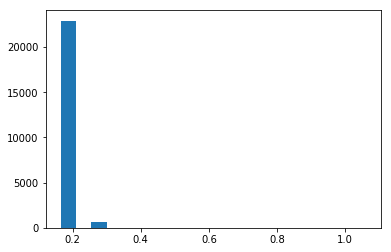

In [54]:
plt.hist(mat[:,:,2].flatten(),bins=20)

In [55]:
mat[:,:,2].max()

1.059293064215418

In [56]:
%load_ext Cython

In [57]:
%%cython --annotate

from itertools import product

import numpy as np

import scipy.stats as stats
dis = stats.norm()
K = lambda x:dis.pdf(x) # h=1

def test(toad, IJ, Y):
    mat = np.empty(toad.shape+(2,))
    for _xy in product(range(toad.shape[1]), range(toad.shape[0])):
        xy = np.array(_xy).astype(float)
        Wx = K(np.abs(xy - IJ).sum(axis=1))
        _X = (xy - IJ).sum(axis=1)
        X = np.c_[np.ones_like(_X), _X]

        a = np.linalg.inv((X.T * Wx) @ X) @ (X.T * Wx) @ Y

        mat[_xy[1], _xy[0], :] = a.squeeze()
    return mat

In [58]:
%%time

mat = test(toad, IJ, Y)

Wall time: 2min 30s


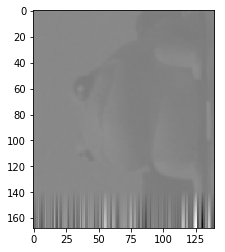

In [59]:
plt.imshow(mat[:,:,0], cmap='gray')

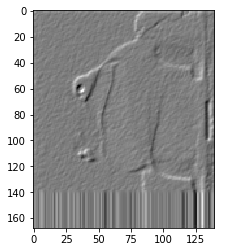

In [60]:
plt.imshow(mat[:,:,1], cmap='gray')

In [61]:
%%time

mat = np.empty(tuple(np.array(toad.shape)//3)+(2,))
for _xy in product(range(toad.shape[1]//3), range(toad.shape[0]//3)):
    xy = np.array(_xy).astype(float)
    Wx = K(np.abs(xy - IJ).sum(axis=1))
    _X = (xy - IJ).sum(axis=1)
    X = np.c_[np.ones_like(_X), _X]
    
    a = np.linalg.inv((X.T * Wx) @ X) @ (X.T * Wx) @ Y
    
    mat[_xy[1], _xy[0], :] = a.squeeze()

Wall time: 16 s


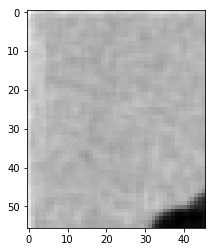

In [62]:
plt.imshow(mat[:,:,0], cmap='gray')

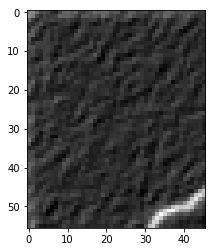

In [63]:
plt.imshow(mat[:,:,1], cmap='gray')